## 1. 시계열의 정상성 테스트

정상성 : 평균, 분산, 공분산 등의 통계적 속성에 시간에 대해 일정한 시계열

In [3]:
import pandas as pd
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from statsmodels.tsa.stattools import adfuller, kpss
import quandl

In [4]:
QUANDL_KEY = '개별 API KEY' # replace {key} with your own API key  
quandl.ApiConfig.api_key = QUANDL_KEY

gold = quandl.get(dataset='WGC/GOLD_MONAVG_USD',start_date='2001-01-01', end_date='2018-12-31')
gold_monthly = gold.resample('M').last()

In [5]:
gold_monthly.head(10)

,Value
Date,
2001-01-31,265.49
2001-02-28,261.86
2001-03-31,263.03
2001-04-30,260.48
2001-05-31,272.35
2001-06-30,270.23
2001-07-31,267.53
2001-08-31,272.39
2001-09-30,283.42


In [8]:
gold_monthly.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 216 entries, 2001-01-31 to 2018-12-31
Freq: M
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Value   216 non-null    float64
dtypes: float64(1)
memory usage: 3.4 KB


### 1) ADF test

In [7]:
adfuller(gold_monthly,autolag='AIC')

(-1.3790201002152396,
 0.5922918005922374,
 1,
 214,
 {'1%': -3.4612821203214907,
  '5%': -2.875142613826617,
  '10%': -2.574020122281422},
 2044.9526441425774)

In [14]:
def adf_test(x):
    indices = ['Test Statistic', 'p-value','# Lags', '# Observation']
    
    adf_test = adfuller(x, autolag='AIC')
    results = pd.Series(adf_test[0:4], index=indices)
    
    for key, value in adf_test[4].items():
        results[f'Critical Value ({key})'] = value

    return results

In [15]:
adf_test(gold_monthly)

Test Statistic           -1.379020
p-value                   0.592292
# Lags                    1.000000
# Observation           214.000000
Critical Value (1%)      -3.461282
Critical Value (5%)      -2.875143
Critical Value (10%)     -2.574020
dtype: float64

p-value가 약 0.59로 '시계열이 정상성이 아니다.'라는 귀무가설을 기각하는 증거가 되지 못한다. 따라서, 금 가격 데이터는 정상성을 만족하지 못한다.

### 2) KPSS test

In [17]:
kpss(gold_monthly,regression='c')

/Users/idong-gyun/opt/miniconda3/envs/py36/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:1875: FutureWarning: The behavior of using nlags=None will change in release 0.13.Currently nlags=None is the same as nlags="legacy", and so a sample-size lag length is used. After the next release, the default will change to be the same as nlags="auto" which uses an automatic lag length selection method. To silence this warning, either use "auto" or "legacy"
  warnings.warn(msg, FutureWarning)
/Users/idong-gyun/opt/miniconda3/envs/py36/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:1907: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warn_msg.format(direction="smaller"), InterpolationWarning


(1.1597963699578604,
 0.01,
 15,
 {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739})

In [18]:
# regression ='c': 귀무가설이 '시계열이 레벨-정상성' 이다.
# regression ='ct': 귀무가설이 '시계열이 추세-정상성' 이다. (추세-정상성: 계열에서 추세를 제거하면 레벨-정상성이 된다.)


def kpss_test(x, h0_type): 
    indices = ['Test Statistic', 'p-value', '# Lags']

    kpss_test = kpss(x, regression=h0_type)
    results = pd.Series(kpss_test[0:3], index=indices)
    
    for key, value in kpss_test[3].items():
        results[f'Critical Value ({key})'] = value

    return results

In [19]:
kpss_test(gold_monthly,'c')

/Users/idong-gyun/opt/miniconda3/envs/py36/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:1907: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warn_msg.format(direction="smaller"), InterpolationWarning


Test Statistic            1.159796
p-value                   0.010000
# Lags                   15.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64

In [20]:
kpss_test(gold_monthly,'ct')

/Users/idong-gyun/opt/miniconda3/envs/py36/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:1907: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warn_msg.format(direction="smaller"), InterpolationWarning


Test Statistic            0.244145
p-value                   0.010000
# Lags                   15.000000
Critical Value (10%)      0.119000
Critical Value (5%)       0.146000
Critical Value (2.5%)     0.176000
Critical Value (1%)       0.216000
dtype: float64

### 3) ACF 그래프 생성

1) ACF : 시차에 따른 일련의 자기 상관을 의미하며, 정상 시계열은 상대적으로 빠르게 0에 수렴하며, 비정상 시계열은 천천히 감소한다. <br> 
$y_t$와 $y_{t+k}$ 사이의 자기상관을 구하는 식은 아래와 같다.

$$
\begin{align}
ACF(k) = \frac{\sum_{t=1}^{N-k}(y_t-\bar{y})(y_{t+k}-\bar{y})}{\sum_{i=1}^{N}(y_t-\bar{y})^2}
\end{align}
$$

2) PACF : 시차에 따른 일련의 편자기 상관이며, 시차가 다른 두 시계열 데이터 간의 순수한 상호 연관성이다. <br>
$y_t$와 $y_{t+k}$ 사이의 편자기상관을 구하는 식은 아래와 같다.

$$
\begin{align}
PACF(k) = Corr(e_t,e_{t-k})
\end{align}
$$

$e_t = y_t - \left(\beta_1y_{t-1}+\cdots+\beta_{k-1}y_{t-(k-1)}\right)$

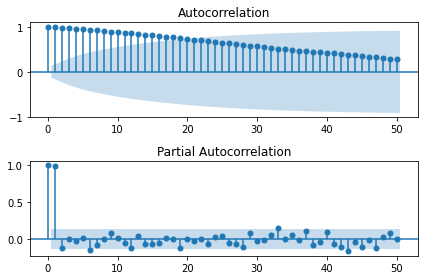

In [24]:
import matplotlib.pyplot as plt

N_LAGS = 50
SIGNIFICANCE_LEVEL = 0.05

fig, ax = plt.subplots(2, 1)
plot_acf(gold_monthly.Value, ax=ax[0], lags=N_LAGS, 
         alpha=SIGNIFICANCE_LEVEL)
plot_pacf(gold_monthly.Value, ax=ax[1], lags=N_LAGS, 
          alpha=SIGNIFICANCE_LEVEL)

plt.tight_layout()
plt.show()

- ACF 그래프에서 천천히 감소하는 형태를 보이므로, 비정상성을 가짐을 알 수 있다. PACF 그래프에서도 lag1, 2 에서 유의한 자기 상관이 있음을 알 수 있다. 

## 2. 시계열 정상성 교정 

### 1) 디플레이션 및 자연 로그 변환 

1) 디플레이션 : 소비자 물가지수를 이용해 인플레이션을 반영한다. <br>
2) 자연 로그 변환 : 추세를 선형에 가깝게 만든다. <br>
3) 차분 : 현 관측값과 지연 값 사이의 차이를 취한다.

- 먼저 소비자 물가지수를 이용하여 금 가격을 디플레이션 시킨다.

In [49]:
import cpi
from datetime import date
import numpy as np

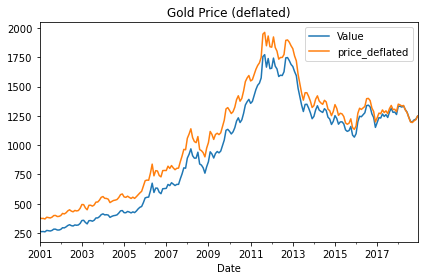

In [50]:
DEFL_DATE = date(2018, 12, 31)

gold_monthly['dt_index'] = gold_monthly.index.map(lambda x: x.to_pydatetime().date())
gold_monthly['price_deflated'] = gold_monthly.apply(lambda x: cpi.inflate(x.Value,x.dt_index, DEFL_DATE), axis=1)
gold_monthly[['Value', 'price_deflated']].plot(title='Gold Price (deflated)')
plt.tight_layout()
plt.show()

- 자연 로그를 사용해 다시 한번 디플레이션 시키고, 시각화한다.

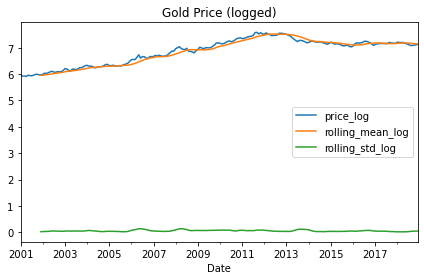

In [52]:
window = 12

selected_columns = ['price_log', 'rolling_mean_log', 'rolling_std_log']

gold_monthly['price_log'] = np.log(gold_monthly.price_deflated)
gold_monthly['rolling_mean_log'] = gold_monthly.price_log.rolling(window).mean()
gold_monthly['rolling_std_log'] = gold_monthly.price_log.rolling(window).std()

gold_monthly[selected_columns].plot(title='Gold Price (logged)')

plt.tight_layout()
plt.show()

위의 그림에서 로그 변환을 했을 때, 추세를 선형에 가깝게 만들어 줄 수 있음을 볼 수 있다.

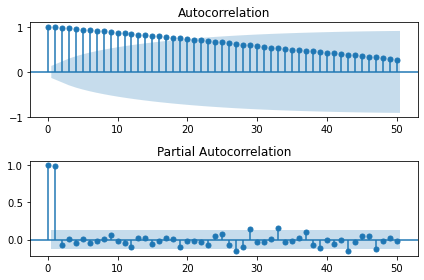

In [53]:
N_LAGS = 50
SIGNIFICANCE_LEVEL = 0.05

fig, ax = plt.subplots(2, 1)
plot_acf(gold_monthly.price_log, ax=ax[0], lags=N_LAGS, 
         alpha=SIGNIFICANCE_LEVEL)
plot_pacf(gold_monthly.price_log, ax=ax[1], lags=N_LAGS, 
          alpha=SIGNIFICANCE_LEVEL)

plt.tight_layout()
plt.show()

ACF 그래프를 확인해 봤을 때, 디플레이션과 자연 로그 변환을 통해서 금 가격을 정상적으로 만들기에는 충분하지 않았다는 것을 알 수 있다.

In [55]:
adf_test(gold_monthly.price_log)

Test Statistic           -2.042539
p-value                   0.268238
# Lags                    1.000000
# Observation           214.000000
Critical Value (1%)      -3.461282
Critical Value (5%)      -2.875143
Critical Value (10%)     -2.574020
dtype: float64

In [56]:
kpss_test(gold_monthly.price_log,'c')

/Users/idong-gyun/opt/miniconda3/envs/py36/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:1875: FutureWarning: The behavior of using nlags=None will change in release 0.13.Currently nlags=None is the same as nlags="legacy", and so a sample-size lag length is used. After the next release, the default will change to be the same as nlags="auto" which uses an automatic lag length selection method. To silence this warning, either use "auto" or "legacy"
  warnings.warn(msg, FutureWarning)
/Users/idong-gyun/opt/miniconda3/envs/py36/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:1907: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warn_msg.format(direction="smaller"), InterpolationWarning


Test Statistic            1.162693
p-value                   0.010000
# Lags                   15.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64

ADF test와 KPSS test 에서도 금 가격 데이터가 정상성을 만족하지 못한다는 것을 알 수 있다.

- 로그 변환한 데이터에 1차 차분을 적용하여 다시 결과를 본다.

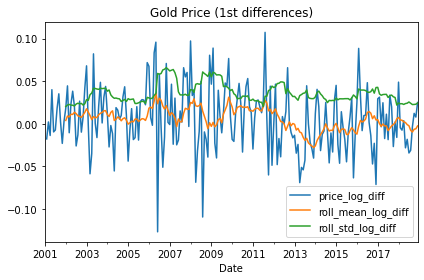

In [58]:
selected_columns = ['price_log_diff', 'roll_mean_log_diff', 'roll_std_log_diff']


gold_monthly['price_log_diff'] = gold_monthly.price_log.diff(1)
gold_monthly['roll_mean_log_diff'] = gold_monthly.price_log_diff.rolling(window).mean()
gold_monthly['roll_std_log_diff'] = gold_monthly.price_log_diff.rolling(window).std()
gold_monthly[selected_columns].plot(title='Gold Price (1st differences)')

plt.tight_layout()
plt.show()

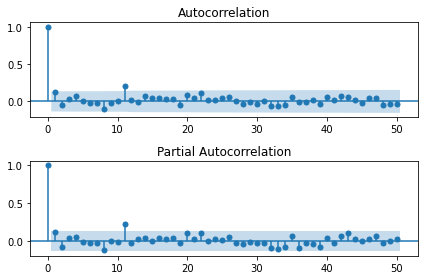

In [60]:
N_LAGS = 50
SIGNIFICANCE_LEVEL = 0.05

fig, ax = plt.subplots(2, 1)
plot_acf(gold_monthly.price_log_diff.dropna(), ax=ax[0], lags=N_LAGS, 
         alpha=SIGNIFICANCE_LEVEL)
plot_pacf(gold_monthly.price_log_diff.dropna(), ax=ax[1], lags=N_LAGS, 
          alpha=SIGNIFICANCE_LEVEL)

plt.tight_layout()
plt.show()

ACF 그래프를 보면, 0으로 빠르게 수렴하는 모습을 보여주므로 정상 시계열의 형태를 보인다고 할 수 있다.

In [61]:
adf_test(gold_monthly.price_log_diff.dropna())

Test Statistic         -1.284916e+01
p-value                 5.398966e-24
# Lags                  0.000000e+00
# Observation           2.140000e+02
Critical Value (1%)    -3.461282e+00
Critical Value (5%)    -2.875143e+00
Critical Value (10%)   -2.574020e+00
dtype: float64

In [62]:
kpss_test(gold_monthly.price_log_diff.dropna(),'c')

/Users/idong-gyun/opt/miniconda3/envs/py36/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:1875: FutureWarning: The behavior of using nlags=None will change in release 0.13.Currently nlags=None is the same as nlags="legacy", and so a sample-size lag length is used. After the next release, the default will change to be the same as nlags="auto" which uses an automatic lag length selection method. To silence this warning, either use "auto" or "legacy"
  warnings.warn(msg, FutureWarning)


Test Statistic            0.473357
p-value                   0.047667
# Lags                   15.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64

ADF test 와 KPSS test 결과를 봤을 때도, 금 가격 데이터가 정상성을 만족한다고 볼 수 있다.

## 차분으로 조정하는 방법

### 1) 차분의 차수 알아내기

In [66]:
from pmdarima.arima import ndiffs, nsdiffs

In [68]:
print(f"Suggested # of differences (ADF): {ndiffs(gold_monthly.Value, test='adf')}")
print(f"Suggested # of differences (KPSS): {ndiffs(gold_monthly.Value, test='kpss')}")
print(f"Suggested # of differences (PP): {ndiffs(gold_monthly.Value, test='pp')}")

Suggested # of differences (ADF): 1
Suggested # of differences (KPSS): 1
Suggested # of differences (PP): 1


시계열 데이터를 1차 차분하면 정상성을 만족함을 위의 결과로 알 수 있다.

In [69]:
### 2) 계절성 검정

In [70]:
print(f"Suggested # of differences (OSCB): {nsdiffs(gold_monthly.Value, m=12, test='ocsb')}")
print(f"Suggested # of differences (CH): {nsdiffs(gold_monthly.Value, m=12, test='ch')}")

Suggested # of differences (OSCB): 0
Suggested # of differences (CH): 0


금 가격에는 계절성이 존재하지 않음을 알 수 있다.